#Import thư viện

In [ ]:
!pip install pandas numpy scikit-fuzzy matplotlib

In [ ]:
!pip install dill


In [ ]:
pip install pyFTS


In [ ]:
%pylab inline
from torch.utils.data import DataLoader
import torch.nn as nn
from pyFTS.partitioners import Grid
from pyFTS.models import chen, cheng
from pyFTS.common import Util , Transformations
from pyFTS.benchmarks import Measures

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['close', 'size']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [ ]:
#Univariate time series
import pandas as pd
import numpy as np
import seaborn as sns
np.int = int
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch.utils.data import TensorDataset, DataLoader
from skfuzzy import control as ctrl

#Phân tích dữ liệu

In [ ]:


df = pd.read_csv('/content/ABBV (AbbVie).csv')

train_size = int(len(df) * 0.7)
train = df["Close"].values[:train_size]
test = df["Close"].values[train_size:]

# df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

train_mv = df.iloc[:train_size]
test_mv = df.iloc[train_size:]

# scaler = MinMaxScaler(feature_range=(0, 1))
# data_scaled = scaler.fit_transform(np.array(df_Close))
# data_scaled = np.squeeze(data_scaled)

# train_size = int(len(df) * 0.7)
# train = df[:train_size]
# test = df[train_size:]

In [ ]:
df.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,1259,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,2021-10-29 23:29:07.100873984,58.066029,58.503979,57.608944,58.057164,54.904554,6.065510e+06
min,2019-05-02 00:00:00,36.810001,37.389999,36.150002,37.279999,32.892746,7.558000e+05
25%,2020-07-30 12:00:00,50.965000,51.295000,50.545000,50.845001,46.687906,3.656700e+06
50%,2021-10-28 00:00:00,57.830002,58.400002,57.509998,58.000000,54.590542,5.011900e+06
75%,2023-01-30 12:00:00,66.140000,66.685001,65.685001,66.209999,64.057072,7.055100e+06
max,2024-05-01 00:00:00,76.500000,76.800003,75.959999,76.410004,76.410004,6.554020e+07
std,NaN,9.194875,9.232301,9.153112,9.193133,10.402008,4.683919e+06


In [ ]:
# Sắp xếp dữ liệu theo cột 'Close'
train = train.sort_values(by='Close')

# Loại bỏ các dòng có giá trị NaN trong dữ liệu
train = train.dropna(subset=['Close'])

In [ ]:
train

array([37.619999, 38.41    , 38.349998, 37.98    , 38.299999, 38.470001,
       37.650002, 37.279999, 37.82    , 37.68    , 37.799999, 37.779999,
       37.540001, 37.880001, 38.610001, 38.66    , 39.02    , 38.009998,
       37.529999, 37.509998, 37.380001, 37.900002, 38.59    , 38.360001,
       38.830002, 39.02    , 39.59    , 39.389999, 39.93    , 39.91    ,
       39.669998, 39.98    , 40.950001, 41.68    , 41.610001, 41.360001,
       41.490002, 41.400002, 40.970001, 40.990002, 41.279999, 41.310001,
       41.709999, 41.990002, 40.939999, 40.830002, 40.740002, 41.130001,
       40.450001, 40.209999, 40.220001, 40.200001, 40.34    , 40.73    ,
       40.119999, 40.330002, 40.580002, 40.349998, 42.66    , 43.509998,
       44.389999, 43.860001, 43.41    , 44.      , 44.279999, 43.560001,
       43.619999, 43.919998, 44.139999, 44.77    , 44.360001, 44.860001,
       43.810001, 44.18    , 44.34    , 44.419998, 44.619999, 45.419998,
       45.41    , 44.580002, 44.830002, 44.880001, 

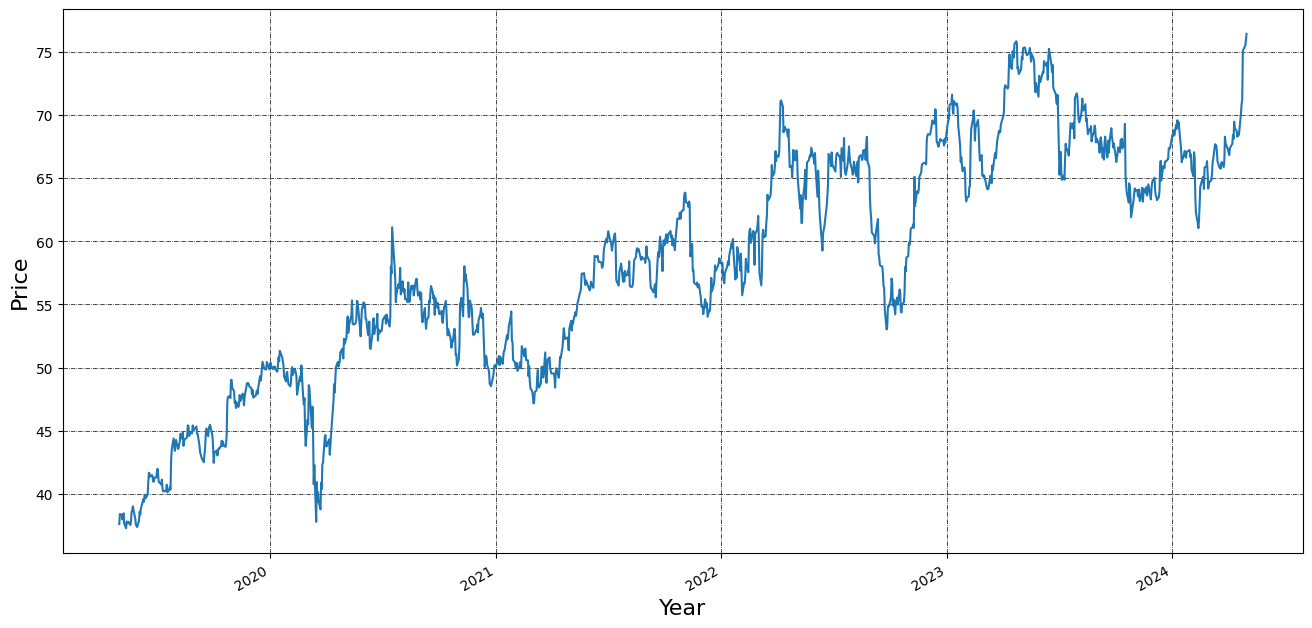

In [ ]:
df['Close'].plot(figsize=(16, 8))

plt.ylabel('Price', fontsize=16)
plt.xlabel('Year', fontsize=16)

plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)

plt.show()

##Biểu đồ Train & Test

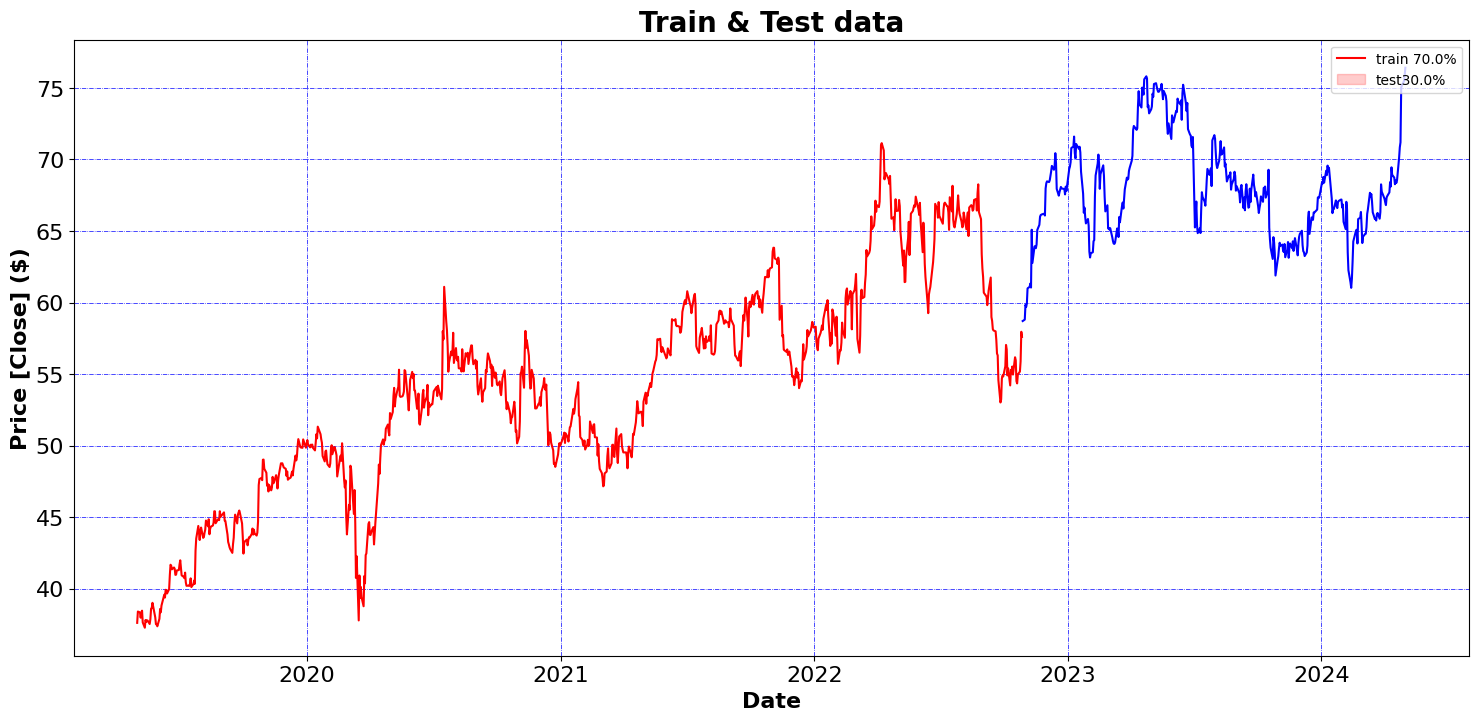

In [ ]:
size = 0.7  # Chia train test
size_train = int(len(df) * size)
fig, ax = plt.subplots(figsize=(18,8)) # 4.5, 2
sns.lineplot(x = df.index[:size_train], y = df['Close'][:size_train], color = 'red')
sns.lineplot(x = df.index[size_train:], y = df['Close'][size_train:], color = 'blue')

ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price [Close] ($)', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train ' + str(size*100) + '%', 'test'+ str(100 - size*100) + '%'))
plt.grid(which="major", color='blue', linestyle='-.', linewidth=0.5)
plt.show()

##Phân chia lưới để xác định các tập mờ

/usr/local/lib/python3.10/dist-packages/pyFTS/partitioners/partitioner.py:238: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(ticks)


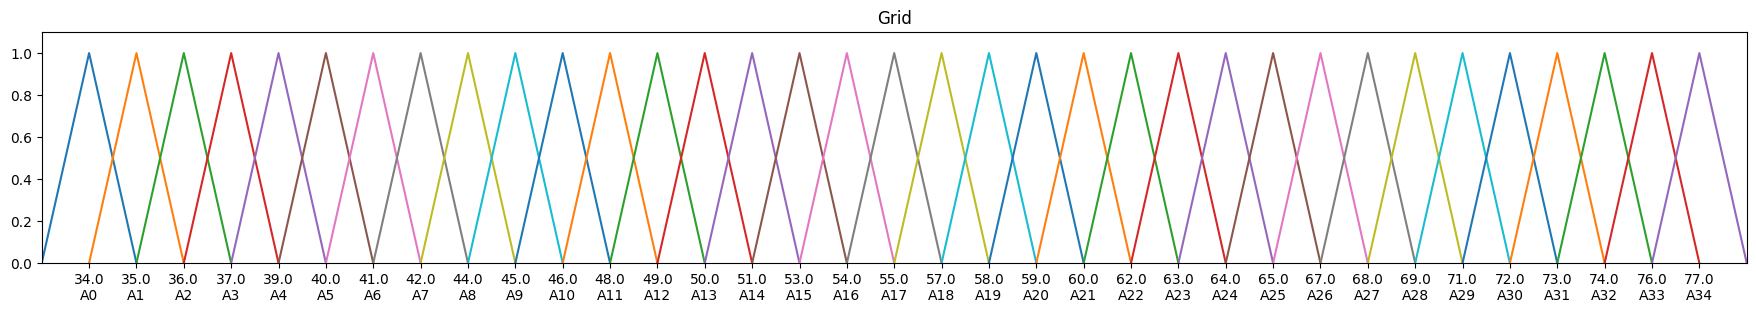

In [ ]:
from pyFTS.partitioners import Grid

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[22,3])
part = Grid.GridPartitioner(data=train,npart=35)

part.plot (ax)

##“mờ hóa” (fuzzyfy) chuỗi dữ liệu huấn luyện

In [ ]:
from pyFTS.common import FuzzySet as fz
F = fz.fuzzyfy_series(train, part.sets)
print (F)



['A3', 'A4', 'A4', 'A3', 'A4', 'A4', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A4', 'A4', 'A4', 'A3', 'A3', 'A3', 'A3', 'A3', 'A4', 'A4', 'A4', 'A4', 'A5', 'A5', 'A5', 'A5', 'A5', 'A5', 'A6', 'A6', 'A6', 'A6', 'A6', 'A6', 'A6', 'A6', 'A6', 'A6', 'A6', 'A7', 'A6', 'A6', 'A6', 'A6', 'A5', 'A5', 'A5', 'A5', 'A5', 'A6', 'A5', 'A5', 'A6', 'A5', 'A7', 'A8', 'A8', 'A8', 'A8', 'A8', 'A8', 'A8', 'A8', 'A8', 'A8', 'A9', 'A8', 'A9', 'A8', 'A8', 'A8', 'A9', 'A9', 'A9', 'A9', 'A9', 'A9', 'A9', 'A9', 'A9', 'A9', 'A9', 'A9', 'A9', 'A9', 'A8', 'A8', 'A7', 'A7', 'A7', 'A7', 'A7', 'A8', 'A9', 'A9', 'A9', 'A9', 'A9', 'A9', 'A9', 'A9', 'A8', 'A7', 'A8', 'A8', 'A8', 'A7', 'A8', 'A8', 'A8', 'A8', 'A8', 'A8', 'A8', 'A8', 'A8', 'A8', 'A9', 'A11', 'A11', 'A11', 'A11', 'A12', 'A12', 'A12', 'A11', 'A11', 'A11', 'A10', 'A11', 'A10', 'A11', 'A11', 'A11', 'A11', 'A11', 'A11', 'A11', 'A11', 'A11', 'A12', 'A12', 'A12', 'A12', 'A12', 'A11', 'A11', 'A11', 'A11', 'A11', 'A11', 'A11', 'A11', 'A12', 'A12', 'A12', '

##Tạo các quy tắc logic mờ (FLR)

In [ ]:
from pyFTS.common import FLR
rules = FLR.generate_non_recurrent_flrs (F)
print ([str(k) for k in rules[0:10]])

['A3 -> A4', 'A4 -> A4', 'A4 -> A3', 'A3 -> A3', 'A4 -> A5', 'A5 -> A5', 'A5 -> A6', 'A6 -> A6', 'A6 -> A7', 'A7 -> A6']


##Nhóm các quy tắc logic mờ (FLRGs)

In [ ]:
from pyFTS.models import chen

model = chen.ConventionalFTS(partitioner=part)
model.fit(train)

print(model)

Conventional FTS:
A3 -> A3,A4,A6
A4 -> A3,A4,A5,A6
A5 -> A4,A5,A6,A7
A6 -> A5,A6,A7
A7 -> A3,A6,A7,A8,A9
A8 -> A10,A7,A8,A9
A9 -> A10,A11,A12,A6,A8,A9
A10 -> A11,A9
A11 -> A10,A11,A12,A9
A12 -> A11,A12,A13,A14
A13 -> A11,A12,A13,A14,A15
A14 -> A12,A13,A14,A15,A17
A15 -> A14,A15,A16,A17
A16 -> A13,A14,A15,A16,A17,A18,A19
A17 -> A15,A16,A17,A18,A19,A20
A18 -> A16,A17,A18,A19,A20
A19 -> A17,A18,A19,A20,A21,A22
A20 -> A18,A19,A20,A21
A21 -> A18,A19,A20,A21,A22
A22 -> A20,A21,A22,A23,A24
A23 -> A20,A22,A23,A24,A25
A24 -> A22,A23,A24,A25,A26
A25 -> A23,A24,A25,A26
A26 -> A24,A25,A26,A27,A28
A27 -> A25,A26,A27,A28
A28 -> A26,A27,A28,A29
A29 -> A27,A29



##Mờ hóa và kết hợp quy tắc

In [ ]:
from pyFTS.common import FuzzySet as fz
f = fz.get_maximum_membership_fuzzyset(6, part.sets)
print (f)

A0: trimf([32.27479910571428, 33.551999099999996, 34.82919909428571])


##Các mô hình đơn biến

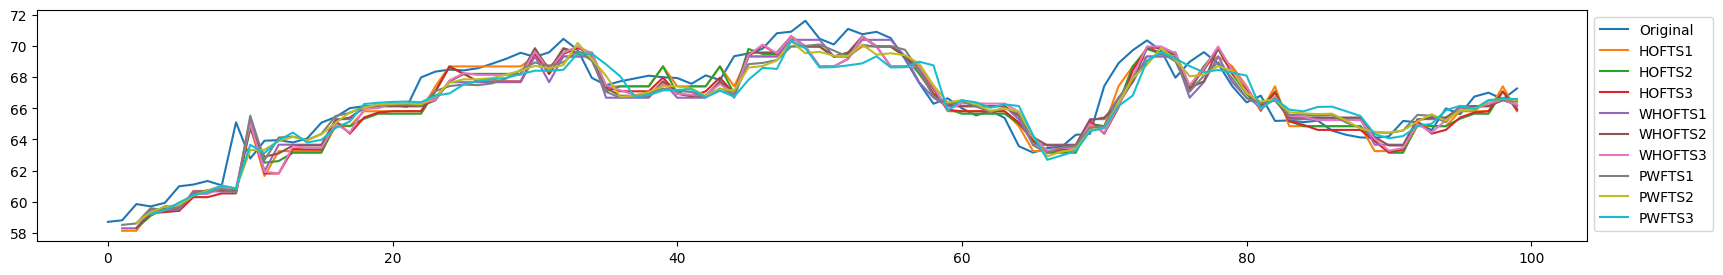

In [ ]:
from pyFTS.common import Util
from pyFTS.models import hofts, pwfts
import numpy as np
models = []
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[20,3])
ax.plot (test[:100], label="Original")
rows = []
test = test[np.isfinite(test)]
for method in [hofts.HighOrderFTS, hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]:
  for order in [1, 2, 3]:
    model = method (partitioner=part, order=order)
    model.shortname += str(order)
    model.fit(train)
    forecasts = model.predict(test)
    for k in np.arange (order) :
      forecasts.insert (0, None)
    ax.plot (forecasts[:100], label=model.shortname)
    models.append (model.shortname)
    Util.persist_obj(model, model.shortname)
    del (model)
handles, labels = ax.get_legend_handles_labels ()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))


##Mô hình đa biến

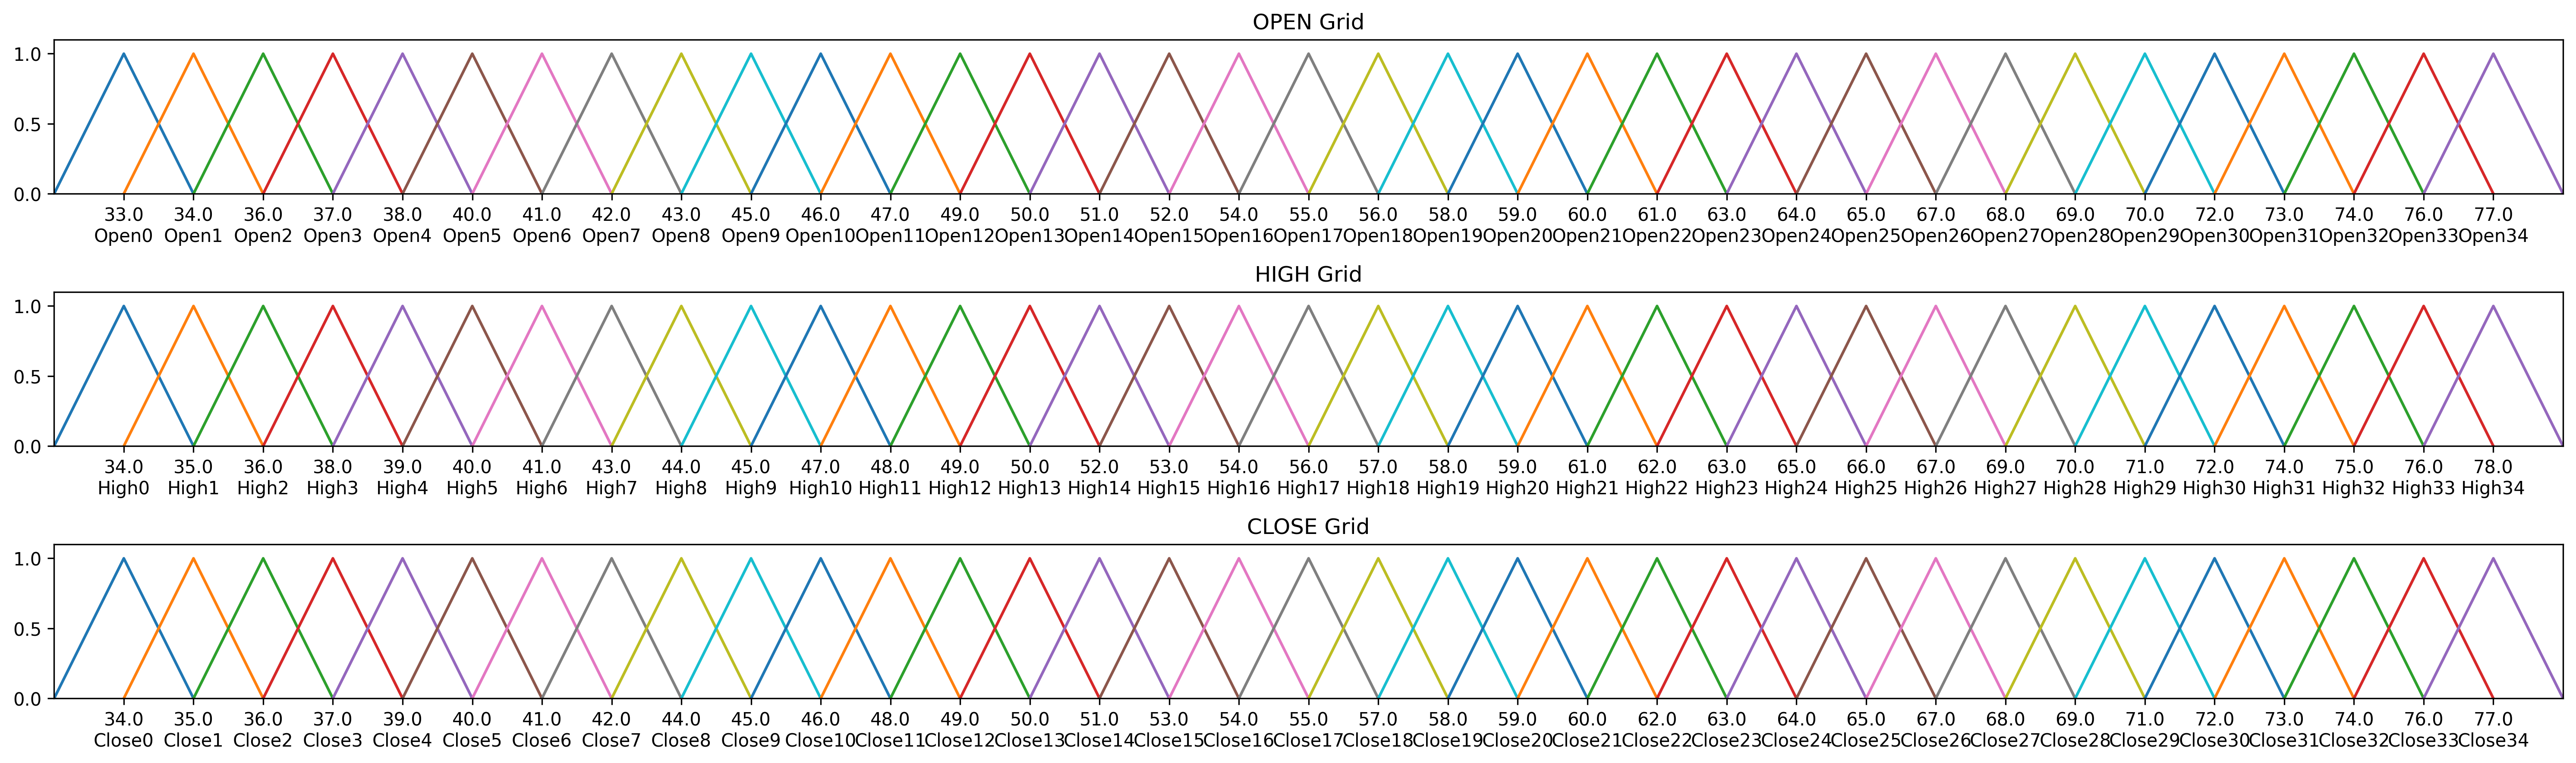

In [ ]:
from pyFTS.partitioners import Grid, Util as pUtil

from pyFTS.models.multivariate import common, variable, mvfts

from pyFTS.models.seasonal import partitioner as seasonal

from pyFTS.models.seasonal.common import DateTime

from pyFTS.common import Util
from pyFTS.partitioners import Grid

vop = variable.Variable ("OPEN", data_label="Open", alias="Open", partitioner=Grid.GridPartitioner, npart=35, data=train_mv)

vhi = variable.Variable ("HIGH", data_label="High", alias='High', partitioner=Grid.GridPartitioner, npart=35, data=train_mv)

vavg = variable.Variable("CLOSE", data_label="Close", alias='Close', partitioner=Grid.GridPartitioner, npart=35, data=train_mv)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=[20,6], dpi=300)

vop.partitioner.plot (ax[0])

vhi.partitioner.plot (ax[1])

vavg.partitioner.plot (ax[2])

plt.tight_layout ()


/usr/local/lib/python3.10/dist-packages/pyFTS/models/hofts.py:253: RuntimeWarning: Mean of empty slice
  final = np.nanmean(midpoints)


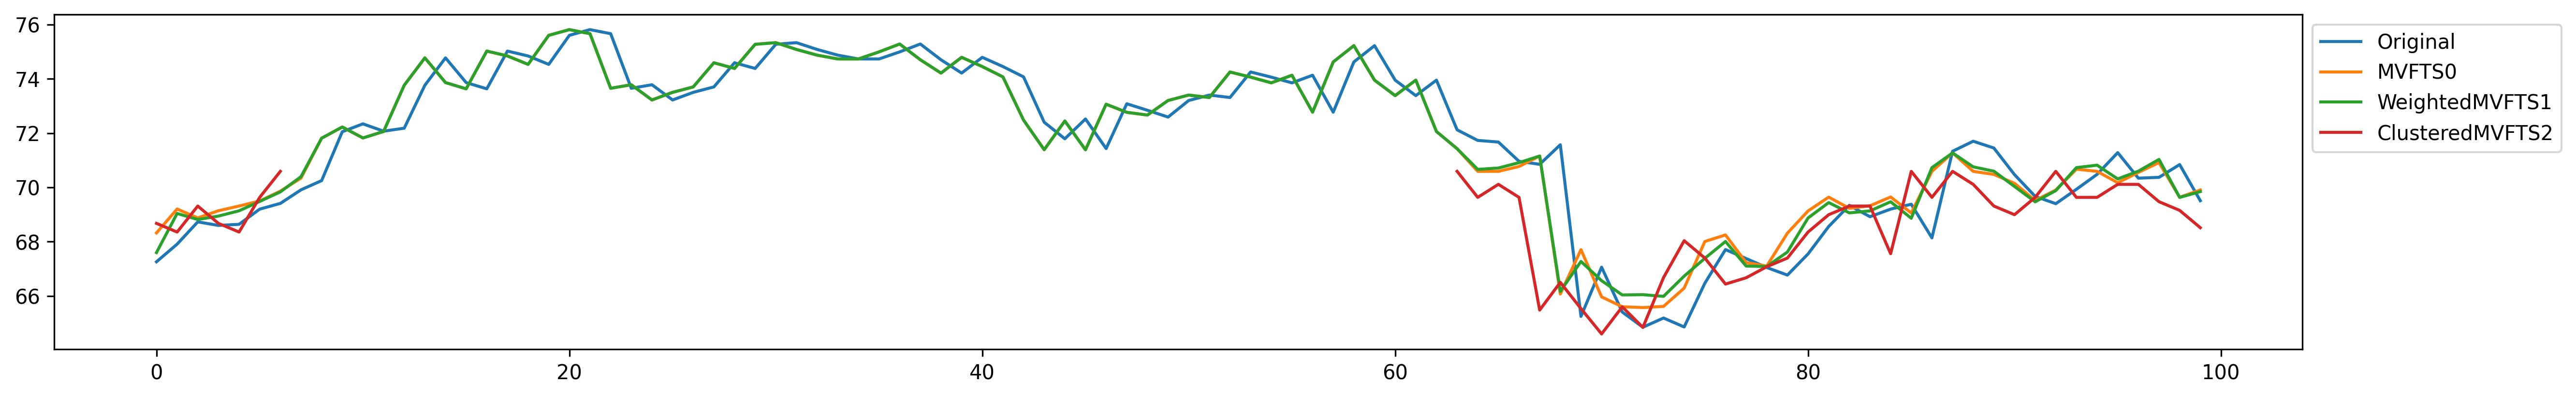

In [ ]:
from pyFTS.models.multivariate import mvfts, wmvfts, cmvfts, grid



fig, ax = plt.subplots (nrows=1, ncols=1, figsize=[20,3], dpi=300)
parameters = [
  {}, {},
  {'order':2, 'knn': 1},
]
ax.plot (test [100:200], label='Original')
for ct, method in enumerate ([mvfts.MVFTS, wmvfts.WeightedMVFTS,cmvfts.ClusteredMVFTS]) :
    try:
      if method != cmvfts.ClusteredMVFTS:
        model = method(explanatory_variables=[vop, vhi, vavg], target_variable=vavg, partitioner=fs, **parameters[ct])
      else:
        fs = grid.GridCluster (explanatory_variables=[vop, vhi, vavg], target_variable=vavg)
        model = method(explanatory_variables=[vop, vhi, vavg], target_variable=vavg, partitioner=fs, **parameters[ct])
      model.shortname += str(ct)
      model.fit (train_mv)
      models.append (model . shortname)
      forecasts = model.predict (test_mv)
      ax.plot (forecasts[100:200], label=model.shortname)
      Util.persist_obj(model, model.shortname)
      del (model)
    except Exception as ex:
      print (method, parameters[ct])
      print (ex)
handles, labels = ax.get_legend_handles_labels ()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
pass

##RMSE của mô hình đơn biến và đa biến

In [ ]:
from pyFTS.benchmarks import Measures
rows = []
for file in models:
  try:
    model = Util.load_obj(file)
    row = [model.shortname, model.order, len(model)]
    if model.is_multivariate:
      rmse, _,_ = Measures.get_point_statistics(test_mv, model)
      row.append (rmse/np.mean (test_mv['avg']))
    else:
      rmse,_,_ = Measures.get_point_statistics(test, model)
      row.append (rmse/np.mean (test))
    rows .append (row)
  except :
    pass
pd.DataFrame (rows, columns=["Model", "Order", "Size", "RMSE"]) .sort_values (["RMSE", "Size"])

/usr/local/lib/python3.10/dist-packages/pyFTS/models/hofts.py:253: RuntimeWarning: Mean of empty slice
  final = np.nanmean(midpoints)


,Model,Order,Size,RMSE
3,WHOFTS1,1,29,0.027398
6,PWFTS1,1,29,0.028429
0,HOFTS1,1,29,0.028871
4,WHOFTS2,2,188,0.028871
1,HOFTS2,2,188,0.029166
5,WHOFTS3,3,830,0.035500
2,HOFTS3,3,830,0.035794
7,PWFTS2,2,188,0.059362
8,PWFTS3,3,830,0.096630


#Dự đoán 30 ngày tiếp theo

In [ ]:

data = df[['Date', 'Close']].dropna()

In [ ]:
# Đặt cột 'Date' làm index
data.set_index('Date', inplace=True)

In [ ]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra với tỷ lệ 7:3
train_size = int(len(data) * 0.7)
train, test = data.iloc[:train_size], data.iloc[train_size:]

In [ ]:
# Chuyển đổi DataFrame sang numpy array
train_mv = train.values
test_mv = test.values

In [ ]:
# Xác định biến fuzzy
date = ctrl.Antecedent(np.arange(0, len(train_mv), 1), 'date')
close = ctrl.Antecedent(np.linspace(min(train_mv[:, 0]), max(train_mv[:, 0]), len(train_mv)), 'close')
prediction = ctrl.Consequent(np.arange(min(train_mv[:, 0]), max(train_mv[:, 0]), 1), 'prediction')


In [ ]:
# Định nghĩa các tập mờ
date.automf(names=['poor', 'average', 'good'])
close.automf(names=['poor', 'average', 'good'])
prediction.automf(names=['poor', 'average', 'good'])

In [ ]:
# Xác định các quy tắc fuzzy
rule1 = ctrl.Rule(date['poor'] | close['poor'], prediction['poor'])
rule2 = ctrl.Rule(date['average'] | close['average'], prediction['average'])
rule3 = ctrl.Rule(date['good'] | close['good'], prediction['good'])

In [ ]:
# Tạo hệ thống kiểm soát
prediction_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
predicting = ctrl.ControlSystemSimulation(prediction_ctrl)

In [ ]:
test_predictions = []
for i in range(len(test)):
    predicting.input['date'] = len(train) + i
    predicting.input['close'] = test['Close'].iloc[i]
    predicting.compute()
    test_predictions.append(predicting.output['prediction'])

In [ ]:
# Tạo DataFrame chứa dự đoán cho tập kiểm tra
test_df = pd.DataFrame({'Test Forecast': test_predictions}, index=test.index)

In [ ]:
test2 = test.copy()
test2_array = test2.values



In [ ]:
# Dự đoán 60 ngày tới
predictions = []
predictions.append(test2_array[-2])
last_date = len(test2_array) - 1
last_close = test2_array[0]  # Giá

In [ ]:
for i in range(30):
    predicting.input['date'] = last_date + i
    predicting.input['close'] = last_close
    predicting.compute()
    predicted_value = predicting.output['prediction']
    predictions.append(predicted_value)
    last_close = predicted_value

In [ ]:
predictions


[array([176.050003]),
 array([122.34297473]),
 array([118.07214162]),
 array([117.98924731]),
 array([118.00537903]),
 array([118.02154965]),
 array([118.03773008]),
 array([118.05392035]),
 array([118.06889901]),
 array([118.08308317]),
 array([118.09727462]),
 array([118.11147356]),
 array([118.12568001]),
 array([118.13989398]),
 array([118.15411548]),
 array([118.16834452]),
 array([118.18061853]),
 array([118.19278561]),
 array([118.20495814]),
 array([118.21713615]),
 array([118.22931964]),
 array([118.24150863]),
 array([118.25370312]),
 array([118.26529086]),
 array([118.27537141]),
 array([118.28545554]),
 array([118.29554341]),
 array([118.30563501]),
 array([118.31573035]),
 array([118.32582943]),
 array([118.33593227])]

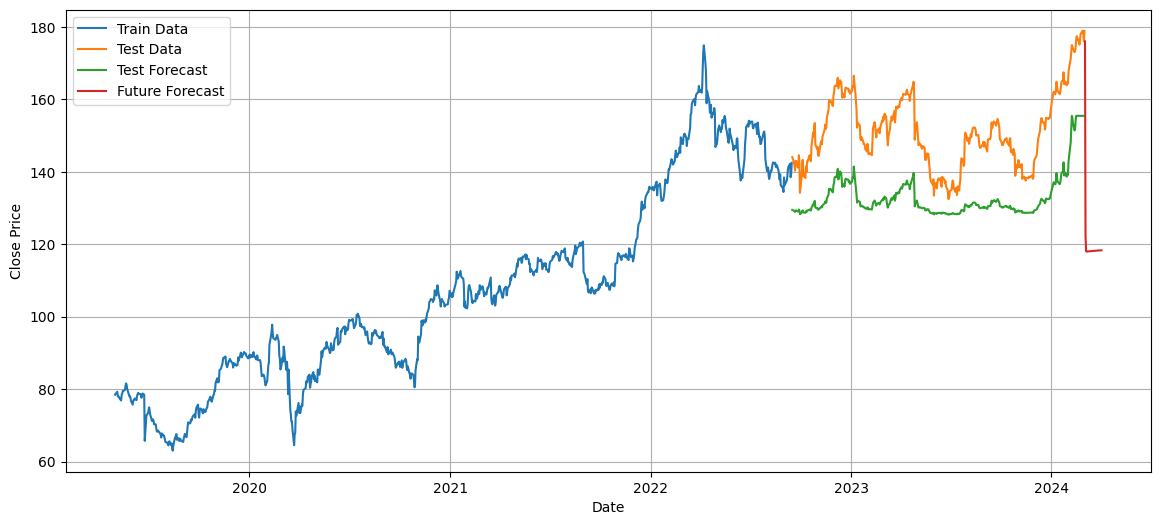

In [ ]:
# Tạo DataFrame chứa dự đoán cho 30 ngày sau
last_date2 = pd.to_datetime(test_df.index[-1])  # Lấy chỉ số cuối cùng của test_df
pred30 = pd.date_range(start=last_date2 + pd.Timedelta(days=1), periods=31, freq='D')
future_df = pd.DataFrame({'Forecast': predictions}, index=pred30)

# Vẽ biểu đồ
plt.figure(figsize=(14, 6))
plt.plot(train.index, train['Close'], label='Train Data')
plt.plot(test.index, test['Close'], label='Test Data')
plt.plot(test_df.index, test_df['Test Forecast'], label='Test Forecast')
plt.plot(future_df.index, future_df['Forecast'], label='Future Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()
